# Poutre appui-appui en flexion, calcul symboliques

## n degrés de liberté

In [60]:
%matplotlib inline
%autosave 300
%clear
import numpy as np
import os

import scipy as sp
from scipy.linalg import eigh # Utile pour traiter le problème aux valeurs propres généralisé

import matplotlib.pyplot as plt
from __future__ import (division, print_function)
from fractions import Fraction
from sympy.core.numbers import I # nombre complexe i

Autosaving every 300 seconds


In [72]:
# Calculs symboliques
import sympy as sy
from sympy.solvers import solve
from sympy.interactive.printing import init_printing
init_printing(use_unicode=False, wrap_line=False, no_global=True) ## Rend les résultats symboliques plus lisibles

from sympy.abc import (x, t, lamda, mu, nu, rho, phi, psi, delta)
xi, x,t = sy.symbols('xi x t')
omega = sy.symbols('omega')

EI, S, L = sy.symbols('EI S L')
rho, M, Iz = sy.symbols('rho M I_z')
dx = sy.symbols('dx') # longueur d'un element

# degres de libertés
# noeud n1
v1 = sy.Function('v_1')
theta1 = sy.Function('theta_1') # degres de libertes
v1p = sy.diff(v1(t), t) # vitesse de translation au noeud
theta1p = sy.diff(theta1(t), t) # vitesse de rotation au noeud
# noeud n2
v2 = sy.Function('v_2')
theta2 = sy.Function('theta_2') # degres de libertes
v2p = sy.diff(v2(t), t) # vitesse de translation au noeud
theta2p = sy.diff(theta2(t), t) # vitesse de rotation au noeud

### Construction de la déformée

#### Tronçon élémentaire $\left[k \cdot dx,(k+1)dx \right]$

In [73]:
K1, K2, K3, K4 = sy.symbols('K_1 K_2 K_3 K_4')

V = 1/6*K1/EI*xi**3 + K2/2/EI*xi**2 + K3*xi + K4 # Deplacement dans l'élément gauche de la poutre
Vprime = 2/dx*sy.diff(V, xi) # dV/dxi = theta(xi)
# Resolution de K1 et K2 en fonctions des deplacements nodaux theta et v:
# noeud n2
V2 = V.subs([(xi, 1)]) # translation au noeud n2
dV2 = Vprime.expand().subs([(xi, 1)]) # rotation au noeud n2
# noeud n1
V1 = V.subs([(xi, -1)]) # translation au noeud n1
dV1 = Vprime.subs([(xi, -1)]).expand() # rotation au noeud n1

a11 = V1.collect((K1,K2,K3,K4), evaluate = False)[K1]
a12 = V1.collect((K1,K2,K3,K4), evaluate = False)[K2]
a13 = V1.collect((K1,K2,K3,K4), evaluate = False)[K3]
a14 = V1.collect((K1,K2,K3,K4), evaluate = False)[K4]

a21 = dV1.collect((K1,K2,K3,K4), evaluate = False)[K1]
a22 = dV1.collect((K1,K2,K3,K4), evaluate = False)[K2]
a23 = dV1.collect((K1,K2,K3,K4), evaluate = False)[K3]
#a24 = dV2.collect((K1,K2,K3,K4), evaluate = False)[K4]
a24 = 0

a31 = V2.collect((K1,K2,K3,K4), evaluate = False)[K1]
a32 = V2.collect((K1,K2,K3,K4), evaluate = False)[K2]
a33 = V2.collect((K1,K2,K3,K4), evaluate = False)[K3]
a34 = V2.collect((K1,K2,K3,K4), evaluate = False)[K4]

a41 = dV2.collect((K1,K2,K3,K4), evaluate = False)[K1]
a42 = dV2.collect((K1,K2,K3,K4), evaluate = False)[K2]
a43 = dV2.collect((K1,K2,K3,K4), evaluate = False)[K3]
a44 = 0 #dV2.collect((K1,K2,K3,K4), evaluate = False)[K4]

AB = sy.Matrix([[a11, a12, a13, a14, v1(t)],[a21, a22, a23, a24, theta1(t)],[a31, a32, a33, a34, v2(t)], [a41, a42, a43, a44, theta2(t)] ])
Ki = sy.solve_linear_system(AB, K1, K2, K3, K4)
K1, K2, K3, K4 = Ki[K1], Ki[K2], Ki[K3], Ki[K4]

# Forme finale du deplacement
V = V.subs([('K_1',K1),('K_2',K2),('K_3',K3),('K_4',K4)])
V = V.expand().collect((v1(t),theta1(t),v2(t),theta2(t)))
Vpoint = sy.diff(V, t) # dV/dx = theta(x)
#v = V*sy.exp(I*omega*t) # v(x,t)

In [74]:
V

In [75]:
K1, K2, K3, K4

### Matrices de masse et de raideur

#### Energies

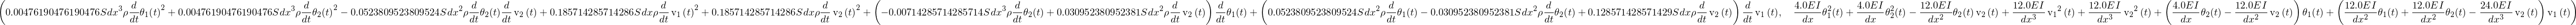

In [76]:
# Energie elastique
U = 8/dx**3*EI*sy.integrate(sy.diff(V, xi, 2)**2, (xi, -1,1))
U = U.expand().collect([v1(t), theta1(t), v2(t), theta2(t)])
# Energie cinetique
T = dx*S*rho/4*sy.integrate(sy.diff(V, t)**2, (xi, -1, 1))
T = T.expand() #+ 1/2*M*v1p**2 + 1/2*Iz*theta1p**2 
T = T.collect([v1(t), theta1(t), v2(t), theta2(t)])

T, U

In [77]:
# Lagrangien
L = T-U
L.expand().collect([v1(t), theta1(t), v2(t), theta2(t)])
# "Premiere ligne" de l equation de Lagrange
eq1 = sy.diff(sy.diff(L,v1p),t) - sy.diff(L, v1(t))
eq1 = eq1.collect([v1(t), theta1(t), v2(t), theta2(t)], evaluate = False)
# "Deuxieme ligne"
eq2 = sy.diff(sy.diff(L,theta1p),t) - sy.diff(L, theta1(t))
eq2 = eq2.collect([v1(t), theta1(t), v2(t), theta2(t)], evaluate = False)
# "troisieme ligne" de l equation de Lagrange
eq3 = sy.diff(sy.diff(L,v2p),t) - sy.diff(L, v2(t))
eq3 = eq3.collect([v1(t), theta1(t), v2(t), theta2(t)], evaluate = False)
# "Quatrieme ligne"
eq4 = sy.diff(sy.diff(L,theta2p),t) - sy.diff(L, theta2(t))
eq4 = eq4.collect([v1(t), theta1(t), v2(t), theta2(t)], evaluate = False)

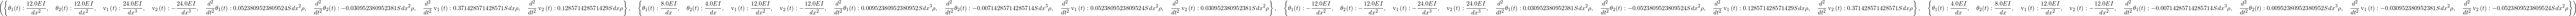

In [78]:
eq1, eq2, eq3, eq4

#### Matrice de raideur

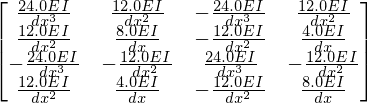

In [79]:
K = sy.zeros(4,4)
K[0,0] = eq1[v1(t)]
K[0,1] = eq1[theta1(t)]
K[0,2] = eq1[v2(t)]
K[0,3] = eq1[theta2(t)]

K[1,0] = eq2[v1(t)]
K[1,1] = eq2[theta1(t)]
K[1,2] = eq2[v2(t)]
K[1,3] = eq2[theta2(t)]

K[2,0] = eq3[v1(t)]
K[2,1] = eq3[theta1(t)]
K[2,2] = eq3[v2(t)]
K[2,3] = eq3[theta2(t)]

K[3,0] = eq4[v1(t)]
K[3,1] = eq4[theta1(t)]
K[3,2] = eq4[v2(t)]
K[3,3] = eq4[theta2(t)]

K

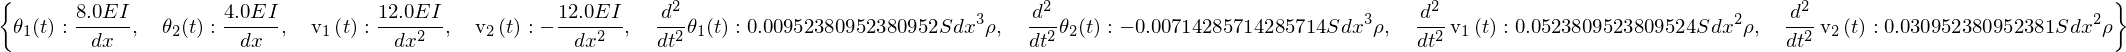

In [80]:
eq2

#### Matrice de masse

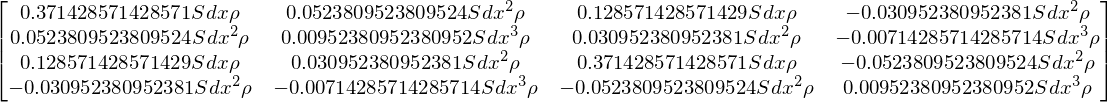

In [81]:
M = sy.zeros(4,4)
M[0,0] = eq1[sy.diff(v1(t),t , 2)]
M[0,1] = eq1[sy.diff(theta1(t),t , 2)]
M[0,2] = eq1[sy.diff(v2(t),t , 2)]
M[0,3] = eq1[sy.diff(theta2(t),t , 2)]
                  
M[1,0] = eq2[sy.diff(v1(t),t , 2)]
M[1,1] = eq2[sy.diff(theta1(t),t , 2)]
M[1,2] = eq2[sy.diff(v2(t),t , 2)]
M[1,3] = eq2[sy.diff(theta2(t),t , 2)]

M[2,0] = eq3[sy.diff(v1(t),t , 2)]
M[2,1] = eq3[sy.diff(theta1(t),t , 2)]
M[2,2] = eq3[sy.diff(v2(t),t , 2)]
M[2,3] = eq3[sy.diff(theta2(t),t , 2)]

M[3,0] = eq4[sy.diff(v1(t),t , 2)]
M[3,1] = eq4[sy.diff(theta1(t),t , 2)]
M[3,2] = eq4[sy.diff(v2(t),t , 2)]
M[3,3] = eq4[sy.diff(theta2(t),t , 2)]

M

### Application numérique

In [82]:
rho = 10000 # kg/m3 : masse volumique de la poutre
b = 0.001 # m : base
h = 0.003 # m : hauteur de la poutre
L = 0.5 # m : longeur de la poutre
EI = 2.1e11*b*h**3 # Nm^2 : module d'Young de la poutre x inertie de section
S = b*h # m2 : section de la poutre
R = 0.05 # m : rayon du disque
m = 10 # kg : masse
Iz = m*R**2 # kg.m2 : moment d'inertie du disque autour de z

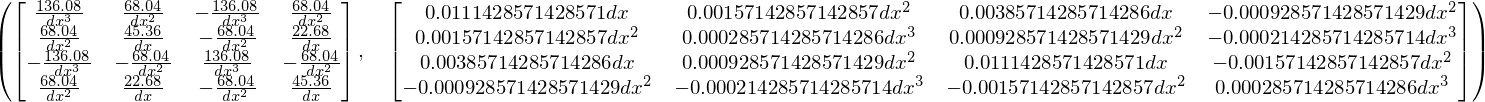

In [83]:
K = K.subs([('EI',EI), ('L',L)])
M = M.subs([('M',m), ('L',L), ('S',S), ('rho',rho), ('I_z',Iz)])
K, M

In [84]:
np.savetxt('results/matrice_nd_k', K)
np.savetxt('results/matrice_nd_m', M)

TypeError: Mismatch between array dtype ('object') and format specifier ('%.18e %.18e %.18e %.18e')